In [31]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # 连接Kaggle
# !pip install -U -q kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"whs2018","key":"7c7b79288ebbf2b31cf55b3dd0e8f295"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# # !kaggle competitions download -c pubg-finish-placement-prediction
# !kaggle datasets download -d rounakbanik/the-movies-dataset

In [ ]:
!pip install deepctr

     |████████████████████████████████| 92kB 3.0MB/s eta 0:00:011


In [ ]:
!pip install surprise

     |████████████████████████████████| 6.5MB 2.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.0-cp36-cp36m-linux_x86_64.whl size=1678212 sha256=a1b475e5ec404d147020cdbdec6ecf86df4445b106f45da66f539a5a0b93ed64
  Stored in directory: /root/.cache/pip/wheels/cc/fa/8c/16c93fccce688ae1bde7d979ff102f7bee980d9cfeb8641bcf
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import torch

import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import surprise as sp
from surprise.model_selection import cross_validate

from deepctr.inputs import SparseFeat, DenseFeat,VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM, xDeepFM, AutoInt, FGCNN, FiBiNET, DIN, DIEN, DSIN, WDL, ONN, WDL

import gc

## 基于矩阵分解的Surprise

In [ ]:
movieslens_rating = pd.read_csv('movieslens-data/ratings.csv')

In [ ]:
movieslens_rating.shape, movieslens_rating.columns

((26024289, 4),
 Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object'))

In [ ]:
def filter_user_item(user_item_rating, min_nb_item_ratings=500, min_nb_user_ratings=300):
    filter_items = (user_item_rating['movieId'].value_counts() > min_nb_item_ratings)
    filter_items = filter_items[filter_items].index.tolist()
    
    filter_users = (user_item_rating['userId'].value_counts() > min_nb_user_ratings)
    filter_users = filter_users[filter_users].index.tolist()
    filter_ret = user_item_rating[(user_item_rating['movieId'].isin(filter_items)) & (user_item_rating['userId'].isin(filter_users))]
    print('Shape User-Ratings unfiltered:\t{}'.format(user_item_rating.shape))
    print('Shape User-Ratings filtered:\t{}'.format(filter_ret.shape))
    return filter_ret

In [ ]:
def get_train_test(filtered_user_item, test_size=0.5):
    X_train, X_test, _, _ = train_test_split(filtered_user_item.reset_index(), filtered_user_item['movieId'].values, test_size=test_size, random_state=2020, stratify=filtered_user_item['movieId'].values)
    return X_train, X_test

In [ ]:
def get_user_item_rating_mat(data):
    return data.pivot_table(index='userId', columns='movieId', values='rating')

In [ ]:
filter_data = filter_user_item(movieslens_rating)
filter_data.shape

Shape User-Ratings unfiltered:	(26024289, 4)
Shape User-Ratings filtered:	(11405024, 4)


(11405024, 4)

In [ ]:
train_data, test_data = get_train_test(filter_data)

In [ ]:
matrix_train_data = get_user_item_rating_mat(train_data)

In [ ]:
matrix_train_data.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,38,39,40,41,42,...,157296,157699,158238,158813,158872,158966,159093,159415,159817,159858,160080,160271,160438,160563,160718,160954,160980,161131,161582,161634,162350,162414,162578,162600,162602,162606,163645,164179,164909,165549,165551,166461,166528,166534,166635,166643,168248,168250,168252,168366
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
24,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,4.5,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,4.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### funkSVD算法
- 原始的SVD算法是不加偏置的即
$$\bar{r_{ui}}=q_i^Tp_u$$
其中$p_u$表示用户因子（embedding向量），$q_i$表示item因子（embedding向量）。

在[Surprise](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)中调用'classsurprise.prediction_algorithms.matrix_factorization.SVD'方法并设置其中参数'biased'为False即为原始的funkSVD算法

In [ ]:
sampled_data = sp.Dataset.load_from_df(movieslens_rating[['userId', 'movieId', 'rating']].sample(200000), sp.Reader())

In [ ]:
# del movieslens_rating
# gc.collect()

41

In [ ]:
results = cross_validate(sp.SVD(biased=False, n_factors=150, n_epochs=100), sampled_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

In [ ]:
funkSVD_ret = pd.DataFrame.from_dict(results).mean(axis=0)
funkSVD_ret

test_rmse     2.309618
test_mae      1.987920
fit_time     59.203200
test_time     0.258414
dtype: float64

#### BiasSVD算法
BiasSVD在funkSVD的基础上添加了用户和item惩罚项，即
$$\bar{r}_{ui}=\mu+b_u+b_i+q_i^Tp_u$$
其中正则化的平方误差损失可以写为
$$\sum_{r_{ui} \in R_{train}} (r_{ui}-\bar{r}_{ui})^2 + \lambda(b_i^2+b_u^2+||q_i||^2 + ||p_u||^2)$$
其中在[Surprise](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)中可设置的参数有'lr_bu','lr_bi','lr_pu','lr_qi','reg_bu','reg_bi','reg_pu'和'reg_qi'，为了简单设置可以仅考虑'lr_all'和'reg_all'。

In [ ]:
results = cross_validate(sp.SVD(n_factors=150, n_epochs=30, lr_all=0.001, reg_all=0.01), sampled_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

In [ ]:
biasSVD_ret = pd.DataFrame.from_dict(results).mean(axis=0)
biasSVD_ret

test_rmse     0.983223
test_mae      0.764089
fit_time     18.292508
test_time     0.279914
dtype: float64

#### SVD++算法
其是对BiasSVD的基础上添加了用户的隐式反馈信息，即
$$\bar{r}_{ui}=\mu + b_u + b_i + q_i^T (p_u + |I_u|^{-\frac{1}{2}}\sum_{j \in I_u})y_j$$
其中$y_j$是隐式反馈（没有具体评分，但可能有点击、浏览等行为），$I(i)$表示他的隐式反馈集合，可以用是否评分进行表示（而与评分值无关）。在[Surprise](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)中的具体调用类函数为'classsurprise.prediction_algorithms.matrix_factorization.SVDpp'。

In [ ]:
results = cross_validate(sp.SVDpp(n_factors=150, n_epochs=30, lr_all=0.001, reg_all=0.01), sampled_data, measures=['RMSE', 'MAE'], cv=5, verbose=False)

In [ ]:
SVDpp_ret = pd.DataFrame.from_dict(results).mean(axis=0)
SVDpp_ret

test_rmse     1.004389
test_mae      0.791526
fit_time     87.552662
test_time     0.625192
dtype: float64

#### 探究向量维度n_factors对评价指标RMSE的影响

若原始rating矩阵维度为$N\times M$，其中rating可以分为两个矩阵p和q，其中p的维度$n\_factors\times M$，q的维度为$n\_factors \times N$。$n\_factor$的维度可以表示物品的类别等隐藏信息。

In [ ]:
n_factors = [3, 5, 10, 50, 500]

In [ ]:
results = []
for nf in tqdm(n_factors):
  results.append(cross_validate(sp.SVDpp(n_factors=nf), sampled_data, measures=['RMSE', 'MAE'], cv=5, verbose=False))

100%|██████████| 5/5 [29:51<00:00, 479.30s/it]


In [ ]:
rmses = []
mses = []
for ret in results:
  rmses.append(np.mean(ret['test_rmse']))
  mses.append(np.mean(ret['test_mae']))

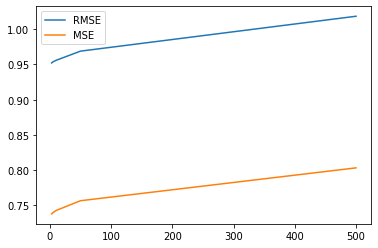

In [ ]:
plt.plot(n_factors, rmses, label='RMSE')
plt.plot(n_factors, mses, label='MSE')
plt.legend()

## 基于协同过滤的Surprise算法

**协同过滤算法**

**基于邻域的协同过滤算法**

In [ ]:
sampled_data = sp.Dataset.load_from_df(movieslens_rating[['userId', 'movieId', 'rating']].sample(20000), sp.Reader())

### KNNBasic算法

In [ ]:
results = cross_validate(sp.KNNBasic(k=20, min_k=1, verbose=False), sampled_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
# 参数classsurprise.prediction_algorithms.knns.KNNBasic(k=40, min_k=1, sim_options={}, verbose=True, **kwargs)

In [ ]:
knnbasic_ret = pd.DataFrame.from_dict(results).mean(axis=0)
knnbasic_ret

test_rmse    1.075544
test_mae     0.856744
fit_time     5.111553
test_time    0.049296
dtype: float64

### KNNWithMeans算法

In [ ]:
results = cross_validate(sp.KNNWithMeans(k=20, min_k=1, verbose=False), sampled_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
# classsurprise.prediction_algorithms.knns.KNNWithMeans(k=40, min_k=1, sim_options={}, verbose=True, **kwargs)

In [ ]:
knnwithmeans_ret = pd.DataFrame.from_dict(results).mean(axis=0)
knnwithmeans_ret

test_rmse    1.113804
test_mae     0.879361
fit_time     4.589478
test_time    0.050304
dtype: float64

### KNNWithZScore算法

In [ ]:
results = cross_validate(sp.KNNWithZScore(k=20, min_k=1, verbose=False), sampled_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
# classsurprise.prediction_algorithms.knns.KNNWithZScore(k=40, min_k=1, sim_options={}, verbose=True, **kwargs)

In [ ]:
knnwithzscore_ret = pd.DataFrame.from_dict(results).mean(axis=0)
knnwithzscore_ret

test_rmse    1.118128
test_mae     0.881744
fit_time     4.884853
test_time    0.050729
dtype: float64

### KNNBaseline算法

In [ ]:
results = cross_validate(sp.KNNWithZScore(k=20, min_k=1, verbose=False), sampled_data, measures=['RMSE', 'MAE'], cv=3, verbose=False)
# classsurprise.prediction_algorithms.knns.KNNBaseline(k=40, min_k=1, sim_options={}, bsl_options={}, verbose=True, **kwargs)

In [ ]:
knnbaseline_ret = pd.DataFrame.from_dict(results).mean(axis=0)
knnbaseline_ret

test_rmse    1.122761
test_mae     0.885895
fit_time     4.744078
test_time    0.050567
dtype: float64

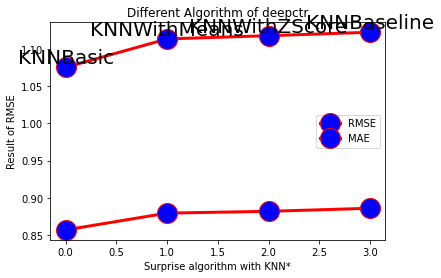

In [ ]:
# KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline
labels = ['KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'KNNBaseline']
value_rmse = [knnbasic_ret.iloc[0], knnwithmeans_ret.iloc[0], knnwithzscore_ret.iloc[0], knnbaseline_ret.iloc[0]]
value_mae = [knnbasic_ret.iloc[1], knnwithmeans_ret.iloc[1], knnwithzscore_ret.iloc[1], knnbaseline_ret.iloc[1]]

plt.title("Different Algorithm of deepctr")

plt.plot(np.arange(0, len(labels)), value_rmse, linewidth=3, color='r', marker='o', label='RMSE',
         markerfacecolor='blue', markersize=20)

plt.plot(np.arange(0, len(labels)), value_mae, linewidth=3, color='r', marker='o', label='MAE',
         markerfacecolor='blue', markersize=20)

plt.xlabel('Surprise algorithm with KNN*')
plt.ylabel('Result of RMSE')
for idx, (a, b) in enumerate(zip(labels, value_rmse)):
  plt.text(idx, b, a, ha='center', va='bottom', fontsize=20)
 
plt.legend()

### 探究不同K值对RMSE的影响
- KNNBasic/KNNBaseline 几乎不受k值影响
- KNNWithMeans/KNNWithZScore 在k至较小的时，较受影响


  0%|          | 0/5 [00:00<?, ?it/s]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...



 20%|██        | 1/5 [00:14<00:56, 14.20s/it]

Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.



 40%|████      | 2/5 [00:28<00:42, 14.15s/it]

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...



 60%|██████    | 3/5 [00:42<00:28, 14.15s/it]

Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...



 80%|████████  | 4/5 [00:56<00:14, 14.14s/it]

Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...



100%|██████████| 5/5 [01:10<00:00, 14.11s/it]


Done computing similarity matrix.


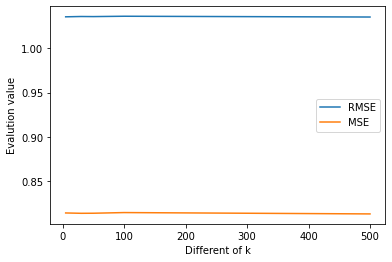

In [ ]:
n_k = [5, 30, 50, 100, 500]
results = []
for k in tqdm(n_k):
  results.append(cross_validate(sp.KNNBaseline(k=k), sampled_data, measures=['RMSE', 'MAE'], cv=3, verbose=False))

rmses = []
mses = []
for ret in results:
  rmses.append(np.mean(ret['test_rmse']))
  mses.append(np.mean(ret['test_mae']))

plt.plot(n_k, rmses, label='RMSE')
plt.plot(n_k, mses, label='MSE')
plt.xlabel('Different of k')
plt.ylabel('Evalution value')
plt.legend()

## 基于deepctr的算法

### DeepFM算法
利用NN的方式拟合结果，具体分为两个model（并行）：使用FM提取低阶特征；使用DNN提取高阶，是一种端到端（end-to-end）的模式，共享隐变量（embedding）参数的输入，即每个特征都单独有一个embedding向量（共享学习）。函数化表示如下：
$$\bar{y}=sigmoid(y_{FM}+y_{DNN})$$
采用concat的方式对结果进行sigmoid。

为了简单验证算法，使用[shenweichen](https://github.com/shenweichen/DeepCTR-Torch)的[examples](https://github.com/shenweichen/DeepCTR-Torch/tree/master/examples)中的'movielens_sample.txt'。

In [ ]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [ ]:
data = pd.read_csv('movieslens-data/movielens_sample.txt')

In [36]:
data.head()

,user_id,movie_id,rating,timestamp,title,genres,gender,age,occupation,zip
0,3299,235,4,968035345,Ed Wood (1994),Comedy|Drama,F,25,4,19119
1,3630,3256,3,966536874,Patriot Games (1992),Action|Thriller,M,18,4,77005
2,517,105,4,976203603,"Bridges of Madison County, The (1995)",Drama|Romance,F,25,14,55408
3,785,2115,3,975430389,Indiana Jones and the Temple of Doom (1984),Action|Adventure,M,18,19,29307
4,5848,909,5,957782527,"Apartment, The (1960)",Comedy|Drama,M,50,20,20009


In [ ]:
sparse_features = ["movie_id", "user_id", "gender", "age", "occupation", "zip", ]
target = ['rating']

In [ ]:
## Label编码稀疏特征
for feat in sparse_features:
  lbe = LabelEncoder()
  data[feat] = lbe.fit_transform(data[feat])
## 序列特征genres处理
key2index = {}
genres_list = list(map(split, data['genres'].values)) # 对genres列每个值进行key-idx的处理，即genres中每个单一值都对应一个index，生成一个二维数组。每一行表示genres的values对应的index。
genres_length = np.array(list(map(len, genres_list))) # 统计每个genres中的长度
max_len = max(genres_length) # 获取最大长度
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post')  # https://blog.csdn.net/wcy23580/article/details/84957471，两个重要参数padding和truncating

**代码解读**
```
class SparseFeat(namedtuple('SparseFeat',['name', 'vocabulary_size', 'embedding_dim', 'use_hash', 'dtype', 'embedding_name','group_name'])):
    __slots__ = ()
    def __new__(cls, name, vocabulary_size, embedding_dim=4, use_hash=False，dtype="int32", embedding_name=None, group_name=DEFAULT_GROUP_NAME):
        if embedding_name is None:
            embedding_name = name
        if embedding_dim == "auto":
            embedding_dim = 6 * int(pow(vocabulary_size, 0.25))
        if use_hash:
            print("Notice! Feature Hashing on the fly currently is not supported in torch version,you can use tensorflow version!")
        return super(SparseFeat, cls).__new__(cls, name, vocabulary_size, embedding_dim, use_hash, dtype, embedding_name, group_name)

    def __hash__(self):
        return self.name.__hash__()


class VarLenSparseFeat(namedtuple('VarLenSparseFeat', ['sparsefeat', 'maxlen', 'combiner', 'length_name'])):
    __slots__ = ()

    def __new__(cls, sparsefeat, maxlen, combiner="mean", length_name=None):
        return super(VarLenSparseFeat, cls).__new__(cls, sparsefeat, maxlen, combiner, length_name)

    @property
    def name(self):
        return self.sparsefeat.name

    @property
    def vocabulary_size(self):
        return self.sparsefeat.vocabulary_size

    @property
    def embedding_dim(self):
        return self.sparsefeat.embedding_dim

    @property
    def dtype(self):
        return self.sparsefeat.dtype

    @property
    def embedding_name(self):
        return self.sparsefeat.embedding_name

    @property
    def group_name(self):
        return self.sparsefeat.group_name

    def __hash__(self):
        return self.name.__hash__()


class DenseFeat(namedtuple('DenseFeat', ['name', 'dimension', 'dtype'])):
    __slots__ = ()

    def __new__(cls, name, dimension=1, dtype="float32"):
        return super(DenseFeat, cls).__new__(cls, name, dimension, dtype)

    def __hash__(self):
        return self.name.__hash__()


def get_feature_names(feature_columns):
    features = build_input_features(feature_columns)
    return list(features.keys())
```
**\_\_new\_\_**

Python的新类允许用户重载\__new__和\__init__方法，且这两个方法具有不同的作用。\__new__作为构造器，起创建一个类实例的作用。而\__init__作为初始化器，起初始化一个已被创建的实例的作用。

**\_\_hash__**

python3中，在set，frozenset，dict这三种数据结构中，都要求键值key是可hash的，因为要保证key的唯一性。而\__hash__实际上是返回一个int值，用来唯一标记这个对象。

**namedtuple**

继承于tuple，它们可以用于任何普通元组，并添加了通过名字获取值的能力，通过索引值也是可以的。

可以知道'SparseFeat'类的主要作用是为利用SparseFeat对稀疏矩阵的基本信息进行命名，并使用特征name对稀疏矩阵中每个特征所对应的信息进行命名。

DenseFeat仅是对类型进行了转化（没有进行内存降低处理）。

VarLenSparseFeat是借助了word2vec的思想，把每个多值特征当成一个句子（vocabulary_size表示词典的大小），其中每个单词（单个向量）都有一个embedding向量，'combiner'表示的神经网络池化层的池化方式。和一般SparseFeat的区别是，vocabulary_size大小的设置，使用VarLenSparseFeat需要设置，SparseFeat可以设置（设置的话表示隐变量）。

In [ ]:
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique(), embedding_dim=4) for feat in sparse_features]  # 对每个稀疏域进行embedding编码
varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean', weight_name=None)]  # 对于每个VarLen长度进行编码

In [ ]:
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [ ]:
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print('cuda ready...')
  device = 'cuda:0'

In [ ]:
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=2020)
def test_deepctr(algo):

  final_ret = 0.0
  for fold_idx, (trn_idx, val_idx) in tqdm(enumerate(kfold.split(data[feature_names]))):
    X_train, X_val = data[feature_names].iloc[trn_idx], data[feature_names].iloc[val_idx]
    y_train, y_val = data[target].iloc[trn_idx], data[target].iloc[val_idx]
    
    train_model_input = {name:X_train[name] for name in feature_names}
    train_model_input['genres'] = genres_list[trn_idx]
    val_model_input = {name:X_val[name] for name in feature_names}
    val_model_input['genres'] = genres_list[val_idx]

    model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, dnn_activation='tanh', dnn_use_bn=False, task='regression')#, device=device) 

    model.compile("adam", "mse", metrics=['mse'], )
    history = model.fit(train_model_input, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(val_model_input, y_val))

    val_pred = model.predict(val_model_input, batch_size=256)
    ret = round(np.sqrt(mean_squared_error(y_val, val_pred)), 5)
    print(f'validation rmse fold {fold_idx+1} : {ret}')
    final_ret += ret
  final_ret /= n_folds
  return final_ret

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, dnn_activation='tanh', dnn_use_bn=False, task='regression')#, device=device) 

In [46]:
deepfm_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:06,  6.18s/it]

validation rmse fold 1 : 1.25531



2it [00:12,  6.29s/it]

validation rmse fold 2 : 1.13739



3it [00:19,  6.50s/it]

validation rmse fold 3 : 1.20885



4it [00:27,  6.83s/it]

validation rmse fold 4 : 1.05439



5it [00:35,  7.16s/it]


validation rmse fold 5 : 1.28012


### xDeepFM算法

xDeepFM是基于vector-wise的，其中已知的DCN网络是基于bit-wise，而xDeepFM的CIN网络是基于vector-wise。

**DCN网络简介**

在DCN网络中使用CrossNet来进行特征提取，具体表示为：
$$y=x_0*x^{\prime}*w + b+ x$$
CrossNet深层网络使用的是函数迭代的形式，具体表示为：
$$x_{l+1} =x_0 x_l^Tw_l + b + x_l = f(x_l, w_l, b_l) + x_l$$，其中$x_{l+1},x_{l},x_0 \in R^d$。

公式推导如下(如CrossNet有2层，且$x_0=[x_{0,1},x_{0,2}]^T$，这个表示)：
$$x_1=x_0x_0^Tw_0 + x_0 = [x_{0,1},x_{0,2}]^T[x_{0,1},x_{0,2}][w_{0,1},w_{0,2}]^T + [x_{0,1},x_{0,2}]^T = [w_{0,1}x^2_{0,1} + w_{0,2}x_{0,1}x_{0,1} + x_{0,1},w_{0,1}x_{0,2}x_{0,1}+w_{0,2}x_{0,2}^2+x_{0,2} ]^T$$
进一步可推到$x_2=\cdots$[link](https://zhuanlan.zhihu.com/p/96827361)

公式可以简化为
$$x_{i+1}=x_0x_i^Tw_{i+1}+x_i=x_0((\alpha^ix_0)^Tw_{i+1}) + \alpha^ix_0=a^{i+1}x_0$$

其中$x_0=$

In [ ]:
model = xDeepFM(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, dnn_activation='tanh', dnn_use_bn=False, task='regression')#, device=device) 

In [48]:
xdeepfm_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:08,  8.78s/it]

validation rmse fold 1 : 1.23064



2it [00:17,  8.87s/it]

validation rmse fold 2 : 1.11048



3it [00:27,  9.24s/it]

validation rmse fold 3 : 1.21288



4it [00:38,  9.61s/it]

validation rmse fold 4 : 1.05739



5it [00:49, 10.04s/it]


validation rmse fold 5 : 1.32405


### AutoInt算法

In [49]:
model = AutoInt(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, dnn_activation='tanh', dnn_use_bn=False, task='regression', att_layer_num=4, att_embedding_size=10, att_head_num=3)#, device=device) 


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
dim is deprecated, use axis instead


In [50]:
autoint_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:11, 11.55s/it]

validation rmse fold 1 : 1.26565



2it [00:23, 11.66s/it]

validation rmse fold 2 : 1.11203



3it [00:36, 11.98s/it]

validation rmse fold 3 : 1.20614



4it [00:49, 12.31s/it]

validation rmse fold 4 : 1.05181



5it [01:02, 12.67s/it]


validation rmse fold 5 : 1.31133


### FiBiNET算法

In [ ]:
model = FiBiNET(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, dnn_activation='tanh', task='regression',)#, device=device) 

In [52]:
fibinet_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:14, 14.60s/it]

validation rmse fold 1 : 1.28827



2it [00:29, 14.69s/it]

validation rmse fold 2 : 1.09311



3it [00:45, 15.04s/it]

validation rmse fold 3 : 1.16975



4it [01:01, 15.35s/it]

validation rmse fold 4 : 1.05831



5it [01:18, 15.72s/it]


validation rmse fold 5 : 1.27743


### ONN算法

In [ ]:
model = ONN(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, task='regression')#, device=device) 

In [54]:
onn_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:17, 17.54s/it]

validation rmse fold 1 : 1.25772



2it [00:35, 17.70s/it]

validation rmse fold 2 : 1.12076



3it [00:54, 17.92s/it]

validation rmse fold 3 : 1.20209



4it [01:12, 18.21s/it]

validation rmse fold 4 : 1.06747



5it [01:32, 18.57s/it]


validation rmse fold 5 : 1.30134


### WDL算法

In [ ]:
model = WDL(linear_feature_columns, dnn_feature_columns, dnn_hidden_units=(256, 256, 256), dnn_dropout=0.0, task='regression')#, device=device)

In [56]:
wdl_ret = test_deepctr(model)


0it [00:00, ?it/s]
1it [00:20, 20.53s/it]

validation rmse fold 1 : 1.25153



2it [00:41, 20.51s/it]

validation rmse fold 2 : 1.14124



3it [01:01, 20.63s/it]

validation rmse fold 3 : 1.20718



4it [01:23, 21.03s/it]

validation rmse fold 4 : 1.05366



5it [01:46, 21.52s/it]


validation rmse fold 5 : 1.30589


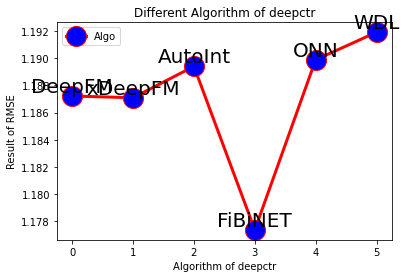

In [57]:
# DeepFM, xDeepFM, AutoInt, FiBiNET, ONN, WDL
labels = ['DeepFM', 'xDeepFM', 'AutoInt', 'FiBiNET', 'ONN', 'WDL']
value = [deepfm_ret, xdeepfm_ret, autoint_ret, fibinet_ret, onn_ret, wdl_ret]


plt.title("Different Algorithm of deepctr")

plt.plot(np.arange(0, len(value)), value, label='Algo', linewidth=3, color='r', marker='o',
         markerfacecolor='blue', markersize=20)
plt.xlabel('Algorithm of deepctr')
plt.ylabel('Result of RMSE')
for idx, (a, b) in enumerate(zip(labels, value)):
  plt.text(idx, b, a, ha='center', va='bottom', fontsize=20)
 
plt.legend()